In [2]:
import pystac_client
import planetary_computer
from pystac_client.stac_api_io import StacApiIO
from urllib3 import Retry

import geopandas as gpd
from odc.geo.geom import BoundingBox
import odc.geo.xr

import pandas as pd
import numpy as np
import xarray as xr
from odc.algo import mask_cleanup
from dea_tools.spatial import xr_rasterize

import requests
import xml.etree.ElementTree as ET
from collections import defaultdict

import odc.stac
from odc.stac import configure_rio
from datacube.utils.aws import configure_s3_access
from distributed import LocalCluster, Client

In [2]:
# Set up Dask Cluster for Parallelization
cluster = LocalCluster(n_workers=12, threads_per_worker=1, processes=False)
client = Client(cluster)
# configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)
configure_rio(cloud_defaults=True, client=client) # For Planetary Computer
print(client.dashboard_link)

http://155.207.39.39:8787/status


c:\Users\fotakidis\anaconda3\envs\sardegna\Lib\site-packages\dask\array\chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
c:\Users\fotakidis\anaconda3\envs\sardegna\Lib\site-packages\dask\array\chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
c:\Users\fotakidis\anaconda3\envs\sardegna\Lib\site-packages\dask\array\chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
c:\Users\fotakidis\anaconda3\envs\sardegna\Lib\site-packages\dask\array\chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
c:\Users\fotakidis\anaconda3\envs\sardegna\Lib\site-packages\dask\array\chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
c:\Users\fotakidis\anaconda3\envs\sardegna\Lib\site-packages\dask\_task_spec.py:740: RuntimeWarning: All-NaN s

In [30]:
def check_gri_refinement(items):
    refined_items = []
    refinement_data = []

    # Loop through items and extract `Image_Refining` flag
    for item in items:
        datastrip_metadata_url = None
        for asset_key, asset_data in items[0].assets.items():
            if "datastrip-metadata" in asset_key.lower(): # and asset_data.href.endswith(".xml"):
                # datastrip_metadata_url = planetary_computer.sign(asset_data.href)
                datastrip_metadata_url = asset_data.href
                break

        if datastrip_metadata_url:
            # print(f"Processing: {datastrip_metadata_url}")
            print(f"Processing: {item.id}") #print(f"Processing: {datastrip_metadata_url}")

            # Fetch XML content
            xml_response = requests.get(datastrip_metadata_url)
            if xml_response.status_code == 200:
                root = ET.fromstring(xml_response.content)

                # Extract Image_Refining flag
                refining_element = root.find(".//Geometric_Info/Image_Refining")
                refining_flag = refining_element.get("flag") if refining_element is not None else "Not Found"

                print(f"Image Refining Flag: {refining_flag}")

                # Store item and status in dataframe
                refinement_data.append({
                    "item_id": item.id,
                    "refinement_status": refining_flag
                })

                # Append to refined_items if the flag is 'REFINED'
                if refining_flag == "REFINED":
                    refined_items.append(item)
            else:
                # print(f"Failed to fetch XML: {xml_response.status_code}")
                refinement_data.append({
                    "item_id": item.id,
                    "refinement_status": "Fetch Failed"
                })
        else:
            # print("datastrip_metadata.xml not found in STAC item")
            refinement_data.append({
                "item_id": item.id,
                "refinement_status": "Metadata Not Found"
            })

    # Create a DataFrame
    df_refinement_status = pd.DataFrame(refinement_data)

    return refined_items, df_refinement_status


In [12]:
aoi = gpd.read_file('../studyarea/AoI1.kml').to_crs('EPSG:4326')
aoi_bbox = BoundingBox.from_xy(
    (aoi.geometry.total_bounds[0],aoi.geometry.total_bounds[2]),
    (aoi.geometry.total_bounds[1], aoi.geometry.total_bounds[3])
    )

In [24]:
aoi_bbox.explore()

In [29]:
aoi_bbox = aoi_bbox.buffered(xbuff=0.05, ybuff=0.05)
aoi_bbox.explore()

To assess the response of forests to the 2024 drought year, we will calculate spectral indices changes (ratios) **<span style="background-color: green">between July 2023 – September 2024</span>** using monthly composites. Images per month will contribute to the monthly composite, resulting in a single representative monthly image.  The median composite approach while it strongly depends on the number of cloud free images available over the area of interest, has been shown to provide robust, consistent results over different studies and remote sensing data (Griffiths et al., 2019) . The following figure (Figure 2.1) summarize the process:

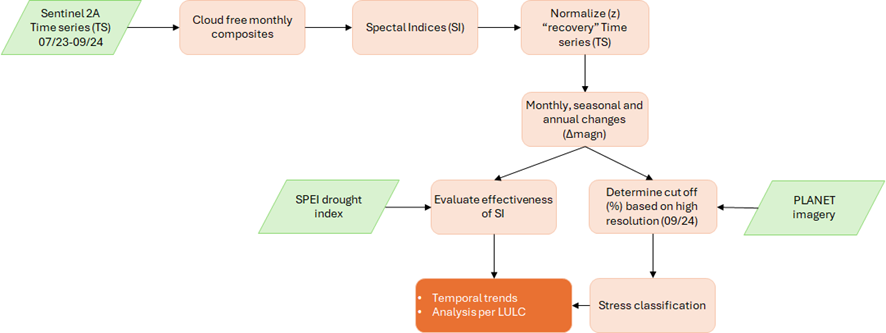

**SR#1: P01/P02. Limited Sentinel-2 Data Availability due to Cloud Cover**

This issue could arise if there are not enough images to generate monthly mosaics-especially due to winter season.
- Mitigation Measures: Develop bi-monthly image composites using Sentinel-2 imagery.
    - Back-up Measures: If bimonthly composites also fail, we will explore integrating Landsat imagery in the process or generating cloud free subsets within each AOI.


In [32]:
stac_api_io = StacApiIO(max_retries=Retry(total=5, backoff_factor=5))

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    stac_io=stac_api_io
)

cloud_cover = 70
search = catalog.search(
    collections=["sentinel-2-l2a"], #hls2-s30
    bbox=aoi_bbox,
    datetime='2024-07',
    limit=100,
    query={
        "eo:cloud_cover": {"lt":cloud_cover},
        "s2:nodata_pixel_percentage": {"lt":20},
    },
)

items = search.item_collection()
print(f'Found {len(items)} items')

Found 14 items


In [ ]:
stac_api_io = StacApiIO(max_retries=Retry(total=5, backoff_factor=5))

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    stac_io=stac_api_io
)

cloud_cover = 70
search = catalog.search(
    collections=["sentinel-2-l2a"], #hls2-s30
    bbox=aoi_bbox,
    datetime='2024-01-01/2024-02-29',
    limit=100,
    query={
        "eo:cloud_cover": {"lt":cloud_cover},
        "s2:nodata_pixel_percentage": {"lt":20},
    },
)

items = search.item_collection()
print(f'Found {len(items)} items')
print(f'Searching for GRI REFINED scenes...')
print(f'###################################')
# Regarding mis-registration (as observed in 2023 vs 2024):
# See: https://forum.step.esa.int/t/geometric-gri-refinement-in-sentinel-2-level-1c-early-images-below-pb-3-0/44024/2
# Finally, the activation of the geometric refining does not mean that the products will be always refined. 
# There are some cases (e.g. too many clouds) where the refining cannot be applied as it would not improve 
# and could degrade the geolocation of the products. This can be checked thanks to the metadata 
# Image_Data_Info/Geometric_Info/Image_Refining in the datastrip matadata file (DATASTRIP/*/MTD_DS.xml). In STAC: datastrip_metadata
# This parameter is equal to REFINED or NOT_REFINED.
#<Geometric_Info metadataLevel="Standard">
#   <RGM>COMPUTED</RGM>
#   <Image_Refining flag="REFINED">
refined_items, df_refinement_status = check_gri_refinement(items)

Found 16 items
Searching for GRI REFINED scenes...
###################################
Processing: S2A_MSIL2A_20240227T100951_R022_T32SMJ_20240227T155958
Image Refining Flag: REFINED
Processing: S2B_MSIL2A_20240222T100939_R022_T32SNJ_20240222T141557
Image Refining Flag: REFINED
Processing: S2B_MSIL2A_20240222T100939_R022_T32SMJ_20240222T141550
Image Refining Flag: REFINED
Processing: S2A_MSIL2A_20240217T101101_R022_T32SNJ_20240217T154810
Image Refining Flag: REFINED
Processing: S2A_MSIL2A_20240217T101101_R022_T32SMJ_20240217T160104
Image Refining Flag: REFINED
Processing: S2B_MSIL2A_20240212T101039_R022_T32SMJ_20240212T150839
Image Refining Flag: REFINED
Processing: S2A_MSIL2A_20240207T101201_R022_T32SNJ_20240207T151948
Image Refining Flag: REFINED
Processing: S2A_MSIL2A_20240207T101201_R022_T32SMJ_20240207T152003
Image Refining Flag: REFINED
Processing: S2B_MSIL2A_20240202T101139_R022_T32SNJ_20240202T151949
Image Refining Flag: REFINED
Processing: S2B_MSIL2A_20240202T101139_R022_T32SN

In [11]:
items = refined_items

if len(items) == 0:        
    msg = f"Search returned 0 Items for `cloud cover`={cloud_cover}. Terminating this composite generation."
    print(msg)
    raise ValueError(msg)
else:
    filtered_items = []
    tiles = np.unique([i.properties['s2:mgrs_tile'] for i in items])
    epsgs = np.unique([i.properties['proj:epsg'] for i in items])
    
    for tile in tiles:
        item_mgrs_sorted = sorted([i for i in items if i.properties['s2:mgrs_tile'] == str(tile)], key=lambda item: item.properties['eo:cloud_cover'])
        if len(item_mgrs_sorted) > 10:
            filtered_items.extend(item_mgrs_sorted[:10])
        else:
            filtered_items.extend(item_mgrs_sorted)
    print(f"Filtered cleanest scenes: Kept {len(filtered_items)} out of {len(items)} items. ")
    print(f"Tiles: {tiles}")
    print(f"EPSG: {epsgs[0]}")
    items = filtered_items
    display(items)

Filtered cleanest scenes: Kept 16 out of 16 items. 
Tiles: ['32SMJ' '32SNJ']
EPSG: 32632


[<Item id=S2B_MSIL2A_20240113T101309_R022_T32SMJ_20240113T131817>,
 <Item id=S2B_MSIL2A_20240222T100939_R022_T32SMJ_20240222T141550>,
 <Item id=S2B_MSIL2A_20240212T101039_R022_T32SMJ_20240212T150839>,
 <Item id=S2B_MSIL2A_20240202T101139_R022_T32SMJ_20240202T151805>,
 <Item id=S2B_MSIL2A_20240202T101139_R022_T32SMJ_20240202T130637>,
 <Item id=S2A_MSIL2A_20240227T100951_R022_T32SMJ_20240227T155958>,
 <Item id=S2A_MSIL2A_20240207T101201_R022_T32SMJ_20240207T152003>,
 <Item id=S2A_MSIL2A_20240217T101101_R022_T32SMJ_20240217T160104>,
 <Item id=S2B_MSIL2A_20240113T101309_R022_T32SNJ_20240113T131816>,
 <Item id=S2B_MSIL2A_20240222T100939_R022_T32SNJ_20240222T141557>,
 <Item id=S2A_MSIL2A_20240207T101201_R022_T32SNJ_20240207T151948>,
 <Item id=S2A_MSIL2A_20240128T101301_R022_T32SNJ_20240128T134330>,
 <Item id=S2B_MSIL2A_20240202T101139_R022_T32SNJ_20240202T151949>,
 <Item id=S2B_MSIL2A_20240202T101139_R022_T32SNJ_20240202T130637>,
 <Item id=S2A_MSIL2A_20240118T101331_R022_T32SNJ_20240118T1519

In [8]:
ds_cube = odc.stac.stac_load(
        items,
        bbox=aoi_bbox,
        bands=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'SCL'],
        chunks=dict(y=1024, x=1024),
        crs='epsg:32632', # Equi7Grid European EPSG (https://github.com/TUW-GEO/Equi7Grid)
        resolution=20,
        groupby='time', # if 'time' loads all items, retaining duplicates
        fail_on_error=True,
        resampling={
            "*": "cubic",
        },
    )
ds_cube

<xarray.Dataset> Size: 2GB
Dimensions:      (y: 1891, x: 1843, time: 9)
Coordinates:
  * y            (y) float64 15kB 4.347e+06 4.347e+06 ... 4.309e+06 4.309e+06
  * x            (x) float64 15kB 4.663e+05 4.664e+05 ... 5.032e+05 5.032e+05
    spatial_ref  int32 4B 32632
  * time         (time) datetime64[ns] 72B 2024-01-13T10:13:09.024000 ... 202...
Data variables: (12/13)
    B01          (time, y, x) float32 125MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B02          (time, y, x) float32 125MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B03          (time, y, x) float32 125MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B04          (time, y, x) float32 125MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B05          (time, y, x) float32 125MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B06          (time, y, x) float32 125MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    ...           ...
    B08          (time, y, x) float32 125MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B8A          (time, y, x) float32 125MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B09          (time, y, x) float32 125MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B11          (time, y, x) float32 125MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B12          (time, y, x) float32 125MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    SCL          (time, y, x) float32 125MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

In [9]:
# - 0: no data
# - 1: saturated or defective
# - 2: dark area pixels
# - 3: cloud shadows
# - 4: vegetation
# - 5: bare soils
# - 6: water
# - 7: unclassified
# - 8: cloud medium probability
# - 9: cloud high probability
# - 10: thin cirrus
# - 11: snow or ice
invalid_scl_values = [3, 7, 8, 9, 10, 11]
cloud_binary_mask = ds_cube.SCL.isin(invalid_scl_values)

bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']
ds_cube_cf = ds_cube[bands].where(~cloud_binary_mask, 0).astype('uint16')
ds_cube_cf

<xarray.Dataset> Size: 753MB
Dimensions:      (time: 9, y: 1891, x: 1843)
Coordinates:
  * y            (y) float64 15kB 4.347e+06 4.347e+06 ... 4.309e+06 4.309e+06
  * x            (x) float64 15kB 4.663e+05 4.664e+05 ... 5.032e+05 5.032e+05
    spatial_ref  int32 4B 32632
  * time         (time) datetime64[ns] 72B 2024-01-13T10:13:09.024000 ... 202...
Data variables:
    B01          (time, y, x) uint16 63MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B02          (time, y, x) uint16 63MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B03          (time, y, x) uint16 63MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B04          (time, y, x) uint16 63MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B05          (time, y, x) uint16 63MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B06          (time, y, x) uint16 63MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B07          (time, y, x) uint16 63MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B08          (time, y, x) uint16 63MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B8A          (time, y, x) uint16 63MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B09          (time, y, x) uint16 63MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B11          (time, y, x) uint16 63MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B12          (time, y, x) uint16 63MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

In [12]:
ds_cube_cf = ds_cube_cf.where(ds_cube_cf > 0, np.nan)
median_composite = ds_cube_cf[bands].median(dim='time').astype('float32').compute()
median_composite

<xarray.Dataset> Size: 167MB
Dimensions:      (y: 1891, x: 1843)
Coordinates:
  * y            (y) float64 15kB 4.347e+06 4.347e+06 ... 4.309e+06 4.309e+06
  * x            (x) float64 15kB 4.663e+05 4.664e+05 ... 5.032e+05 5.032e+05
    spatial_ref  int32 4B 32632
Data variables:
    B01          (y, x) float32 14MB 1.332e+03 1.337e+03 ... 1.27e+03 1.271e+03
    B02          (y, x) float32 14MB 1.457e+03 1.562e+03 ... 1.24e+03 1.247e+03
    B03          (y, x) float32 14MB 1.757e+03 1.963e+03 ... 1.106e+03 1.114e+03
    B04          (y, x) float32 14MB 1.508e+03 2.131e+03 ... 1.053e+03 1.043e+03
    B05          (y, x) float32 14MB 2.514e+03 2.336e+03 ... 1.041e+03 1.04e+03
    B06          (y, x) float32 14MB 4.185e+03 4.282e+03 ... 1.026e+03 1.032e+03
    B07          (y, x) float32 14MB 4.902e+03 4.943e+03 ... 1.036e+03 1.044e+03
    B08          (y, x) float32 14MB 5.372e+03 4.637e+03 ... 1.035e+03 1.043e+03
    B8A          (y, x) float32 14MB 5.036e+03 5.022e+03 ... 1.032e+03 1.024e+03
    B09          (y, x) float32 14MB 5.587e+03 5.545e+03 ... 965.0 972.5
    B11          (y, x) float32 14MB 3.319e+03 3.244e+03 ... 1.028e+03 1.028e+03
    B12          (y, x) float32 14MB 2.331e+03 2.296e+03 ... 1.026e+03 1.022e+03

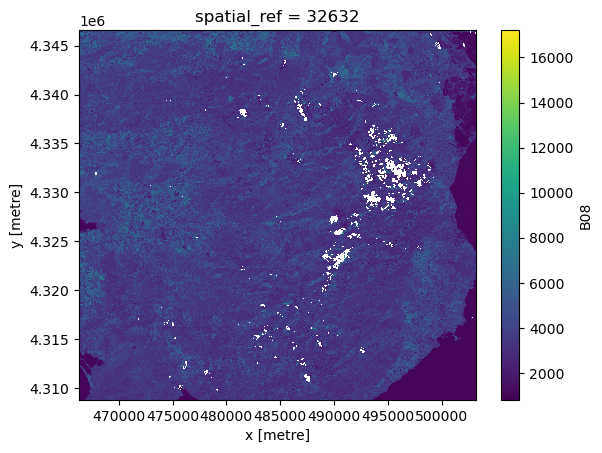

In [14]:
median_composite.B08.plot()

In [22]:
nuts = gpd.read_file('../ancilliary/NUTS_RG_01M_2024_4326.shp/')

In [23]:
nuts[nuts['NAME_LATN']=='Sardegna'].explore()

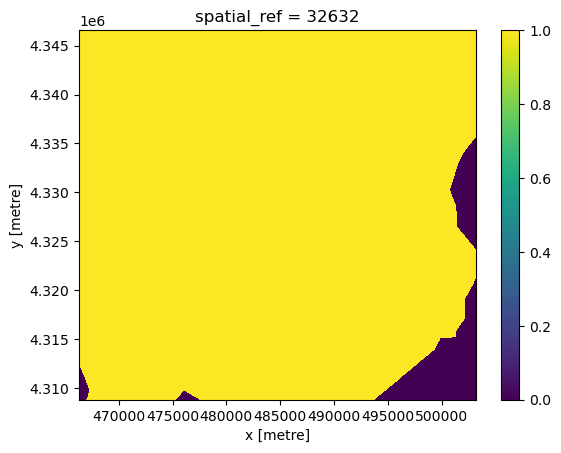

In [27]:
coastline_xr = xr_rasterize(nuts[nuts['NAME_LATN']=='Sardegna'], median_composite)
coastline_xr.plot()

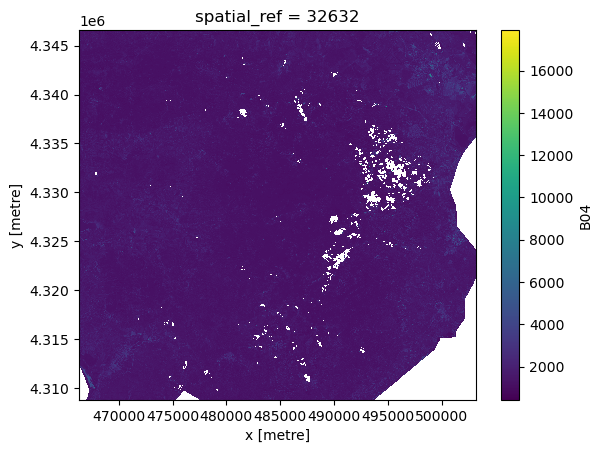

In [28]:
median_composite.where(coastline_xr).B04.plot()